<a href="https://colab.research.google.com/github/luyangsi/is590SCLtestrepo/blob/main/Crossref_Sample_Analysis_Luyang_edit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retraction Status Analysis and Extrapolation Pipeline

This notebook analyzes retraction statuses within the sampled DOI from Crossref that are indexed as retracted paper by April 2023, focusing on


*   Identifying patterns
*   Evaluating patterns that are making correct/incorrect preditions
*   Extrapolating the findings to a larger dataset


### Input and Output Files

- **Input Files**:
    - `crossref_sample_data_validation_set.xlsx`
    - `crossref_only_all_patterns.csv`
- **Output Files**:
    - `crossref_2023-04-05_sampled_retraction_flag_assessment.csv`
    
  

# **1.Data Preparation**


In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import os,re
from collections import Counter
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Wedge, ConnectionPatch
from collections import Counter
#from google.colab import drive

In [405]:

#drive.mount('/content/drive/')

#file_path = '/content/drive/MyDrive/colab/with_Luyang/'  # update this path with yours

In [406]:
# Read the Excel file

data_folder = "../data"  
file_path = os.path.join(data_folder, "crossref_sample_data_validation_set.xlsx")

data = pd.read_excel(file_path)

# Rename column 'Luyang_Label' to 'Label'
data = data.rename(columns={"Luyang_Label": "Label"})

#

# Check the first few rows of the cleaned data
data.head()

,Unnamed: 0,DOI,Author,Title,Year,Journal,source,PubMedID,Group,Title_lower,Journal_lower,Count,Label_ID,Label,Malik_Label_Validation,Jodi_Label_Validation,Remark,Retraction_Phrase,Inference Possibility,Inference Number
0,74,10.1007/s10586-021-03373-6,"[{'given': 'Mengyao', 'family': 'Zhang', 'sequ...",RETRACTED ARTICLE: Lightweight security scheme...,2021,Cluster Computing,Crossref,NaN,likely_retracted,retracted article: lightweight security scheme...,cluster computing,2,RP52,both_rp_rn,NaN,NaN,NaN,retracted article,RP52-N,0
1,75,10.1007/s10586-017-0942-0,"[{'given': 'Chang-Woo', 'family': 'Song', 'seq...",RETRACTED ARTICLE: Development of a medical bi...,2017,Cluster Computing,Crossref,NaN,likely_retracted,retracted article: development of a medical bi...,cluster computing,2,RP52,retracted paper(rp),NaN,NaN,NaN,retracted article,RP52-N,0
2,86,10.1016/j.lfs.2016.05.038,"[{'given': 'Neetu', 'family': 'Kalra', 'sequen...",RETRACTED: Erratum to ‚Äö√Ñ√∫Resveratrol induc...,2016,Life Sciences,Crossref,NaN,likely_retracted,retracted: erratum to ‚Äö√Ñ√∫resveratrol induc...,life sciences,3,RP179,retraction notice(rn),NaN,NaN,NaN,retracted:,RP179-N,0
3,87,10.1016/j.lfs.2020.117519,Ying Pu;Juan Xiang;Jiani Zhang,RETRACTED: KDM5B-mediated microRNA-448 up-regu...,2020,Life Sciences,PubMed; Crossref,32147429.0,likely_retracted,retracted: kdm5b-mediated microrna-448 up-regu...,life sciences,3,RP179,retracted paper(rp),NaN,NaN,NaN,retracted:,RP179-N,0
4,108,10.1016/j.procs.2017.05.073,"[{'given': 'Nikita', 'family': 'Bukhanov', 'se...",RETRACTED: Clustering of comorbidities based o...,2017,Procedia Computer Science,Crossref,NaN,likely_retracted,retracted: clustering of comorbidities based o...,procedia computer science,2,RP228,retraction notice(rn),NaN,NaN,NaN,retracted:,RP228-N,0


In [407]:
# Check duplicated in the dataset
data[data.duplicated(keep=False)]

,Unnamed: 0,DOI,Author,Title,Year,Journal,source,PubMedID,Group,Title_lower,Journal_lower,Count,Label_ID,Label,Malik_Label_Validation,Jodi_Label_Validation,Remark,Retraction_Phrase,Inference Possibility,Inference Number
28,38,10.1080/23311932.2017.1333269,NaN,RETRACTED ARTICLE: Some quality attributes of ...,2017,Cogent Food &amp; Agriculture,Crossref,NaN,likely_retracted,retracted article: some quality attributes of ...,cogent food &amp; agriculture,2,RP54,retraction notice(rn),NaN,NaN,NaN,retracted article,RP54-Y,1
29,38,10.1080/23311932.2017.1333269,NaN,RETRACTED ARTICLE: Some quality attributes of ...,2017,Cogent Food &amp; Agriculture,Crossref,NaN,likely_retracted,retracted article: some quality attributes of ...,cogent food &amp; agriculture,2,RP54,retraction notice(rn),NaN,NaN,NaN,retracted article,RP54-Y,1


In [408]:
# Drop duplicate rows
data.drop_duplicates(inplace=True)
len(data)

926

In [409]:
# Check if any of the title flags are not part of "withdrawal" only. If yes, it should be dropped  - not meet retracted & retraction notice pattern requirement
data[data['Title'].str.lower().str.contains("withdrawal")]['Title_lower']

231    retracted article:.notice of withdrawal
397                          withdrawal notice
Name: Title_lower, dtype: object

In [410]:
# Check the index - double-checking
data.loc[[397]]

,Unnamed: 0,DOI,Author,Title,Year,Journal,source,PubMedID,Group,Title_lower,Journal_lower,Count,Label_ID,Label,Malik_Label_Validation,Jodi_Label_Validation,Remark,Retraction_Phrase,Inference Possibility,Inference Number
397,95,10.1177/0033294119853951,NaN,Withdrawal Notice,2019,Psychological Reports,Crossref,NaN,likely_retraction,withdrawal notice,psychological reports,4,RN386,retraction notice(rn),NaN,NaN,NaN,notice,RN386-Y,1


In [411]:
# Drop the row and reset the index
# data.loc[397]['Title'] # is Withdrawal Notice - to be removed
# - We removed '10.1177/0033294119853951' from analysis due to its withdrawal status i.e. "withdrawal" - not meet retracted & retraction notice pattern requirement

data = data.drop(index=397)
data = data.reset_index(drop=True)

len(data)

925

In [412]:
# Checking "N/A" value in the label
data[data['Label'].isna()]

,Unnamed: 0,DOI,Author,Title,Year,Journal,source,PubMedID,Group,Title_lower,Journal_lower,Count,Label_ID,Label,Malik_Label_Validation,Jodi_Label_Validation,Remark,Retraction_Phrase,Inference Possibility,Inference Number


In [413]:
# Replace "N/A" with "Not Available" -- not to be omitted in the analysis
data['Label']= data['Label'].fillna("Not Available")
data[data['Label']=="Not Available"]

,Unnamed: 0,DOI,Author,Title,Year,Journal,source,PubMedID,Group,Title_lower,Journal_lower,Count,Label_ID,Label,Malik_Label_Validation,Jodi_Label_Validation,Remark,Retraction_Phrase,Inference Possibility,Inference Number


#### Preliminary Results

In [414]:
print(f"Total number of items in the dataset: {len(data)}")

Total number of items in the dataset: 925


In [415]:
# data['Group'].value_counts().plot(kind='bar')

print(f"Total number of items with retracted and retraction notice flags in the dataset")
result1_df= data['Group'].value_counts().reset_index()
result1_df['percentage'] = ((result1_df['count'] / result1_df['count'].sum()) * 100).round(2)
result1_df

Total number of items with retracted and retraction notice flags in the dataset


,Group,count,percentage
0,likely_retraction,594,64.22
1,likely_retracted,331,35.78


In [416]:
print(f"Publishers' status: the label category found on the Publishers website:")
result2_df= data.Label.value_counts().reset_index()
result2_df['percentage'] = ((result2_df['count'] / result2_df['count'].sum()) * 100).round(2)
result2_df

Publishers' status: the label category found on the Publishers website:


,Label,count,percentage
0,retraction notice(rn),661,71.46
1,both_rp_rn,138,14.92
2,retracted paper(rp),119,12.86
3,recheck,7,0.76


In [417]:
result2_df['count'].sum()

np.int64(925)

In [418]:
data.columns

Index(['Unnamed: 0', 'DOI', 'Author', 'Title', 'Year', 'Journal', 'source',
       'PubMedID', 'Group', 'Title_lower', 'Journal_lower', 'Count',
       'Label_ID', 'Label', 'Malik_Label_Validation', 'Jodi_Label_Validation',
       'Remark', 'Retraction_Phrase', 'Inference Possibility',
       'Inference Number'],
      dtype='object')

#### **Extract Flag in the Titles**


In [419]:
def shuffle_pattern(list_of_items: list)->list:
  """It sorts out list and arrange items in descending and lenghty order"""
  list_of_items= list(set(list_of_items))
  list_of_items = sorted(list_of_items, key=lambda x: (-len(x.strip()), x.strip()))
  return list_of_items

# Patterns in identifying retraction notices

rn_startswith= ["<b>retraction notice:</b>",
        "<b>retraction",
        "[retraction]",
        "<b>statement of removal:</b>",
        "correction to: retracted article:",
        "correction to:",
        "correction:",
        "corrigendum to",
        "duplicate:",
        "editorial statement on",
        "erratum to:",
        "erratum zu:",
        "erratum: retracted",
        "notice of duplicate publication:",
        "notice of duplicate publication",
        "notice of retraction",
        "partial retraction:",
        "removal notice:",
        "removal:",
        "removed:",
        "retracted article: retraction",
        "retracted article: statement of retraction",
        "retraction and republication:",
        "retraction for",
        "retraction note to:",
        "retraction note",
        "retraction notice for",
        "retraction notice:",
        "retraction statement for",
        "retraction:",
        "retraction",
        "retrait",
        "sogc guideline retirement notice",
        "statement of retraction for",
        "statement of retraction:",
        "statement of retraction",
        "temporary removal:",
        "<i>retraction</i>",
        "¬†",
        "¬†¬†¬†",
        "author's retraction",
        "authorial statement",
        "correction",
        "corrigendum",
        "editorial removal",
        "editorial retraction",
        "hatalƒ± doi",
        "notice of redundant publication",
        "notice",
        "partial retraction notice",
        "publisher's notice",
        "removal statement",
        "retracted article: statement of retraction",
        "retraction note",
        "retraction notice:",
        "retraction notice",
        "retraction of articles",
        "retraction statement:",
        "retraction statement",
        "retraction",
        "retractions",
        "revise and republish notice",
        "statement of removal",
        "<b>statement of retraction:</b>",
        "statement of retraction.",
        "statement of retraction:",
        "statement of retraction",
        "statement of retractions",
        "<b>retraction notice:</b> ",
        "<b>statement of removal:</b> ",
        " <b>retraction:</b>",
        "[retraction]",
        "retractación"]


rn_startswith= shuffle_pattern(rn_startswith)


rn_endswith= [":retraction","retraction", "retraction notice", "corrigendum"]
rn_endswith= shuffle_pattern(rn_endswith)


# Patterns in identifying retracted items
rp_startswith = [
    "retracted article:",
    "retracted chapter:",
    "retracted chapter",
    "retracted article: retraction",
    "retracted article: retraction:",
    "retracted: retraction notice to",
    "retracted: retraction notice:",
    "retracted: retraction notice",
    "retracted: corrigendum to",
    "retracted: erratum to",
    "retracted article: statement of retraction:"
    "retracted article: statement of retraction",
    "retracted article",
    "retracted manuscript:",
    "retracted manuscript",
    "retracted:",
    "[retracted]",
    "<i>retracted:</i>",
    "<i>retracted",
    "retracted"]

rp_startswith= shuffle_pattern(rp_startswith)

rp_endswith= ["retracted","retracted","corrigendum"]
rp_endswith= shuffle_pattern(rp_endswith)

In [420]:
"RETRACTED: Corrigendum to".lower()

'retracted: corrigendum to'

In [421]:
rn_startswith

['retracted article: statement of retraction',
 'correction to: retracted article:',
 'notice of duplicate publication:',
 'sogc guideline retirement notice',
 '<b>statement of retraction:</b>',
 'notice of duplicate publication',
 'notice of redundant publication',
 'retracted article: retraction',
 'retraction and republication:',
 '<b>statement of removal:</b>',
 '<b>statement of removal:</b> ',
 'revise and republish notice',
 'statement of retraction for',
 '<b>retraction notice:</b> ',
 '<b>retraction notice:</b>',
 'partial retraction notice',
 'retraction statement for',
 'statement of retraction.',
 'statement of retraction:',
 'statement of retractions',
 'statement of retraction',
 'editorial statement on',
 'retraction of articles',
 'retraction notice for',
 'retraction statement:',
 'editorial retraction',
 'notice of retraction',
 'retraction statement',
 'statement of removal',
 "author's retraction",
 'authorial statement',
 'partial retraction:',
 'retraction note to:

In [422]:
rp_startswith

['retracted article: statement of retraction:retracted article: statement of retraction',
 'retracted: retraction notice to',
 'retracted article: retraction:',
 'retracted article: retraction',
 'retracted: retraction notice:',
 'retracted: retraction notice',
 'retracted: corrigendum to',
 'retracted manuscript:',
 'retracted: erratum to',
 'retracted manuscript',
 'retracted article:',
 'retracted chapter:',
 '<i>retracted:</i>',
 'retracted article',
 'retracted chapter',
 '<i>retracted',
 '[retracted]',
 'retracted:',
 'retracted']

In [423]:
"""
Weird labels search:

retracted: retraction notice



"""
search_term= r'retraction\.'
search_term= r'retracted: retraction notice' # (2) -> Rn
search_term= r'correction to: retracted article:'
search_term= r'removal'
search_term= r'correction'

data[data['Title'].str.lower().str.contains(search_term)]

,Unnamed: 0,DOI,Author,Title,Year,Journal,source,PubMedID,Group,Title_lower,Journal_lower,Count,Label_ID,Label,Malik_Label_Validation,Jodi_Label_Validation,Remark,Retraction_Phrase,Inference Possibility,Inference Number
611,619,10.1080/00396338.2020.1833553,NaN,Correction,2020,Survival,Crossref,NaN,likely_retraction,correction,survival,1,RN416,retraction notice(rn),NaN,NaN,NaN,correction,RN416-Y,1
612,620,10.1080/13636820.2020.1870837,NaN,Correction,2020,Journal of Vocational Education &amp; Training,Crossref,NaN,likely_retraction,correction,journal of vocational education &amp; training,1,RN319,retraction notice(rn),NaN,NaN,NaN,correction,RN319-Y,1


In [424]:
data.columns

Index(['Unnamed: 0', 'DOI', 'Author', 'Title', 'Year', 'Journal', 'source',
       'PubMedID', 'Group', 'Title_lower', 'Journal_lower', 'Count',
       'Label_ID', 'Label', 'Malik_Label_Validation', 'Jodi_Label_Validation',
       'Remark', 'Retraction_Phrase', 'Inference Possibility',
       'Inference Number'],
      dtype='object')

In [425]:
data.head(10)

,Unnamed: 0,DOI,Author,Title,Year,Journal,source,PubMedID,Group,Title_lower,Journal_lower,Count,Label_ID,Label,Malik_Label_Validation,Jodi_Label_Validation,Remark,Retraction_Phrase,Inference Possibility,Inference Number
0,74,10.1007/s10586-021-03373-6,"[{'given': 'Mengyao', 'family': 'Zhang', 'sequ...",RETRACTED ARTICLE: Lightweight security scheme...,2021,Cluster Computing,Crossref,NaN,likely_retracted,retracted article: lightweight security scheme...,cluster computing,2,RP52,both_rp_rn,NaN,NaN,NaN,retracted article,RP52-N,0
1,75,10.1007/s10586-017-0942-0,"[{'given': 'Chang-Woo', 'family': 'Song', 'seq...",RETRACTED ARTICLE: Development of a medical bi...,2017,Cluster Computing,Crossref,NaN,likely_retracted,retracted article: development of a medical bi...,cluster computing,2,RP52,retracted paper(rp),NaN,NaN,NaN,retracted article,RP52-N,0
2,86,10.1016/j.lfs.2016.05.038,"[{'given': 'Neetu', 'family': 'Kalra', 'sequen...",RETRACTED: Erratum to ‚Äö√Ñ√∫Resveratrol induc...,2016,Life Sciences,Crossref,NaN,likely_retracted,retracted: erratum to ‚Äö√Ñ√∫resveratrol induc...,life sciences,3,RP179,retraction notice(rn),NaN,NaN,NaN,retracted:,RP179-N,0
3,87,10.1016/j.lfs.2020.117519,Ying Pu;Juan Xiang;Jiani Zhang,RETRACTED: KDM5B-mediated microRNA-448 up-regu...,2020,Life Sciences,PubMed; Crossref,32147429.0,likely_retracted,retracted: kdm5b-mediated microrna-448 up-regu...,life sciences,3,RP179,retracted paper(rp),NaN,NaN,NaN,retracted:,RP179-N,0
4,108,10.1016/j.procs.2017.05.073,"[{'given': 'Nikita', 'family': 'Bukhanov', 'se...",RETRACTED: Clustering of comorbidities based o...,2017,Procedia Computer Science,Crossref,NaN,likely_retracted,retracted: clustering of comorbidities based o...,procedia computer science,2,RP228,retraction notice(rn),NaN,NaN,NaN,retracted:,RP228-N,0
5,109,10.1016/j.procs.2015.08.298,"[{'given': 'Peter', 'family': 'Luong', 'sequen...",RETRACTED: An adaptive predictor for system pr...,2015,Procedia Computer Science,Crossref,NaN,likely_retracted,retracted: an adaptive predictor for system pr...,procedia computer science,2,RP228,retracted paper(rp),NaN,NaN,NaN,retracted:,RP228-N,0
6,282,10.1016/j.matlet.2020.128178,"[{'given': 'Bowen', 'family': 'Gao', 'sequence...",RETRACTED: Corrigendum to ‚Äö√Ñ√∫CH3NH3PbI3 pe...,2020,Materials Letters,Crossref,NaN,likely_retracted,retracted: corrigendum to ‚Äö√Ñ√∫ch3nh3pbi3 pe...,materials letters,2,RP184,retraction notice(rn),NaN,NaN,NaN,corrigendum to,RP184-N,0
7,283,10.1016/j.matlet.2020.127995,"[{'given': 'Bowen', 'family': 'Gao', 'sequence...",RETRACTED: CH3NH3PbI3 perovskite solar cells w...,2020,Materials Letters,Crossref,NaN,likely_retracted,retracted: ch3nh3pbi3 perovskite solar cells w...,materials letters,2,RP184,retracted paper(rp),NaN,NaN,NaN,retracted:,RP184-N,0
8,326,10.1016/j.purol.2018.07.283,"[{'given': 'M.', 'family': 'Roupr‚àö‚Ñ¢t', 'se...",RETRACTED: Recommandations fran‚àö√üaises du C...,2018,Progr‚àö¬Æs en Urologie,Crossref,NaN,likely_retracted,retracted: recommandations fran‚àö√üaises du c...,progr‚àö¬Æs en urologie,2,RP234,both_rp_rn,NaN,NaN,NaN,retracted:,RP234-N,0
9,327,10.1016/j.purol.2018.10.003,"[{'given': 'A.', 'family': 'M‚àö¬©jean', 'sequ...",RETRACTED: Actualisation 2018‚Äö√Ñ√¨2020 des r...,2018,Progr‚àö¬Æs en Urologie,Crossref,NaN,likely_retracted,retracted: actualisation 2018‚Äö√Ñ√¨2020 des r...,progr‚àö¬Æs en urologie,2,RP234,retracted paper(rp),NaN,NaN,NaN,retracted:,RP234-N,0


In [426]:
"""
Adding Retraction Flag and Retraction Flag Position columns to data
"""


data['Retraction_Flag'] = None
data['Retraction_Flag_Pos']= None

# Clean the title -> titles_lower
def clean_title(title: str, df: pd.DataFrame()):
  """
  It cleans the title column in the DataFrame.
  """
  titles_lower = (
      df[title]
      .str.lower()
      .fillna('')
      .astype(str)
      .str.strip()
      .str.replace(r'\s+', ' ', regex=True)  # remove extra space
      # .str.replace(r'\s*:\s*', ':', regex=True)  # Remove space around colons
      # .str.replace(r'\s*-\s*', '-', regex=True)  # Remove space around hyphens
  )

  return titles_lower

# Call function clean_title() to clean the title
titles_lower = clean_title('Title', data)


# Exact for both retracted & retraction notice first before begin & end for retracted paper, and then retraction notice
"""
Exact Matches: Check for exact matches of retracted and retraction notice phrases
"""

# Retracted: Occur as an exact match for retracted phrases
for phrase in rp_startswith:

  # Occur as an exact match of the title?
  mask = (titles_lower == phrase.lower()) & data['Retraction_Flag'].isna()
  data.loc[mask, 'Retraction_Flag'] = phrase
  data.loc[mask, 'Retraction_Flag_Pos'] = 'exact'


# Retraction notice: Occur as an exact match for retraction notice phrases
for phrase in rn_startswith:
  # Occur as an exact match of the title?
  mask2 = (titles_lower == phrase.lower()) & data['Retraction_Flag'].isna()
  data.loc[mask2, 'Retraction_Flag'] = phrase
  data.loc[mask2, 'Retraction_Flag_Pos'] = 'exact'




"""
Start & End Matches: Check for retracted phrases.
"""

# Occur at the start of the title?
for phrase in rp_startswith:

  # Occur at the start of the title?
  mask = titles_lower.str.startswith(phrase.lower()) & data['Retraction_Flag'].isna()
  data.loc[mask, 'Retraction_Flag'] = phrase
  data.loc[mask, 'Retraction_Flag_Pos'] = 'begin'



# Occur at the end of the title?
for phrase in rp_endswith:
  mask = titles_lower.str.endswith(phrase.lower()) & data['Retraction_Flag'].isna()
  data.loc[mask, 'Retraction_Flag'] = phrase
  data.loc[mask, 'Retraction_Flag_Pos'] = 'end'


"""
Start & End Matches: Check for retraction notice phrases
"""
# Occur at the start of the title?

for phrase in rn_startswith:

  # Occur at the start of the title?
  mask = titles_lower.str.startswith(phrase.lower()) & data['Retraction_Flag'].isna()
  data.loc[mask, 'Retraction_Flag'] = phrase
  data.loc[mask, 'Retraction_Flag_Pos'] = 'begin'



# Occur at the end of the title?
for phrase in rn_endswith:
  mask = titles_lower.str.endswith(phrase.lower()) & data['Retraction_Flag'].isna()
  data.loc[mask, 'Retraction_Flag'] = phrase
  data.loc[mask, 'Retraction_Flag_Pos'] = 'end'

# #retracted article: retraction

In [427]:
# Save Data to File
data_folder = "../data"  
file_path = os.path.join(data_folder, "crossref_2023-04-05_sampled_retraction_flag_assessment.csv")
data.to_csv(file_path, index=False)

In [428]:
# These are titles that have retracted and retraction notice phrases in their titles
data_df=data[~data['Retraction_Flag'].isna()].copy()

print(f"The total # of item considered for our analysis {len(data_df)} items")
data_df

The total # of item considered for our analysis 925 items


,Unnamed: 0,DOI,Author,Title,Year,Journal,source,PubMedID,Group,Title_lower,...,Label_ID,Label,Malik_Label_Validation,Jodi_Label_Validation,Remark,Retraction_Phrase,Inference Possibility,Inference Number,Retraction_Flag,Retraction_Flag_Pos
0,74,10.1007/s10586-021-03373-6,"[{'given': 'Mengyao', 'family': 'Zhang', 'sequ...",RETRACTED ARTICLE: Lightweight security scheme...,2021,Cluster Computing,Crossref,NaN,likely_retracted,retracted article: lightweight security scheme...,...,RP52,both_rp_rn,NaN,NaN,NaN,retracted article,RP52-N,0,retracted article:,begin
1,75,10.1007/s10586-017-0942-0,"[{'given': 'Chang-Woo', 'family': 'Song', 'seq...",RETRACTED ARTICLE: Development of a medical bi...,2017,Cluster Computing,Crossref,NaN,likely_retracted,retracted article: development of a medical bi...,...,RP52,retracted paper(rp),NaN,NaN,NaN,retracted article,RP52-N,0,retracted article:,begin
2,86,10.1016/j.lfs.2016.05.038,"[{'given': 'Neetu', 'family': 'Kalra', 'sequen...",RETRACTED: Erratum to ‚Äö√Ñ√∫Resveratrol induc...,2016,Life Sciences,Crossref,NaN,likely_retracted,retracted: erratum to ‚Äö√Ñ√∫resveratrol induc...,...,RP179,retraction notice(rn),NaN,NaN,NaN,retracted:,RP179-N,0,retracted: erratum to,begin
3,87,10.1016/j.lfs.2020.117519,Ying Pu;Juan Xiang;Jiani Zhang,RETRACTED: KDM5B-mediated microRNA-448 up-regu...,2020,Life Sciences,PubMed; Crossref,32147429.0,likely_retracted,retracted: kdm5b-mediated microrna-448 up-regu...,...,RP179,retracted paper(rp),NaN,NaN,NaN,retracted:,RP179-N,0,retracted:,begin
4,108,10.1016/j.procs.2017.05.073,"[{'given': 'Nikita', 'family': 'Bukhanov', 'se...",RETRACTED: Clustering of comorbidities based o...,2017,Procedia Computer Science,Crossref,NaN,likely_retracted,retracted: clustering of comorbidities based o...,...,RP228,retraction notice(rn),NaN,NaN,NaN,retracted:,RP228-N,0,retracted:,begin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,1743,10.1017/s144678872200012x,"[{'given': 'J.', 'family': 'BECK', 'sequence':...",THE KRONECKER‚Äö√Ñ√¨WEYL EQUIDISTRIBUTION THEO...,2022,Journal of the Australian Mathematical Society,Crossref,NaN,likely_retraction,the kronecker‚Äö√Ñ√¨weyl equidistribution theo...,...,RN308,retraction notice(rn),NaN,NaN,NaN,retraction,RN308-Y,1,retraction,end
921,1744,10.1192/bji.2018.18,"[{'given': 'O.', 'family': 'Atilola', 'sequenc...",The Nigerian juvenile justice system: from war...,2018,BJPsych International,Crossref,NaN,likely_retraction,the nigerian juvenile justice system: from war...,...,RN56,retraction notice(rn),NaN,NaN,NaN,retraction,RN56-Y,1,retraction,end
922,1745,10.1017/s0013091521000377,"[{'given': 'Dongni', 'family': 'Tan', 'sequenc...",The wigner property for CL-spaces and finite-d...,2021,Proceedings of the Edinburgh Mathematical Society,Crossref,NaN,likely_retraction,the wigner property for cl-spaces and finite-d...,...,RN376,retraction notice(rn),retraction notice(rn),NaN,NaN,retraction,RN376-Y,1,retraction,end
923,1746,10.1364/josab.36.002876,"[{'given': 'Julia', 'family': 'Zhu', 'sequence...",Thomson backscattering in combined uniform mag...,2019,Journal of the Optical Society of America B,Crossref,NaN,likely_retraction,thomson backscattering in combined uniform mag...,...,RN311,retraction notice(rn),retraction notice(rn),NaN,M: Rn & Rp DOI are different and their pages a...,retraction,RN311-Y,1,retraction,end


In [429]:
pos= 'exact'
grp= 'likely_retraction'
data_df[(data_df['Group']==grp) & (data_df['Retraction_Flag_Pos']==pos)]['Retraction_Flag'].value_counts()

Retraction_Flag
retraction                                    166
statement of retraction                       164
retraction notice                             100
statement of removal                           32
editorial retraction                           16
retraction statement                           11
retracted article: statement of retraction      8
notice of retraction                            6
retraction note                                 4
editorial removal                               3
retracted article: retraction                   3
notice of redundant publication                 3
retractions                                     3
corrigendum                                     2
removal statement                               2
statement of retractions                        2
correction                                      2
retraction statement:                           1
notice                                          1
publisher's notice                

In [430]:
data_df['Group'].value_counts().reset_index()

,Group,count
0,likely_retraction,594
1,likely_retracted,331


# **2.General Retraction Status Analysis and Visualization**

### **Answer To RQ1**

In [431]:
#Group data by retraction status

# Replace a specific label value for consistency
data_df["Label"]=data["Label"].replace("retraction paper(rp)","retracted paper(rp)")

# Calculate the value counts for each retraction status
d_counts=data_df["Label"].value_counts()

# Calculate the percentage for each retraction status
d_percentages=data_df["Label"].value_counts(normalize=True)*100

# Create a new DataFrame to display the counts and percentages
result=pd.DataFrame({
        'Count': d_counts,
        'Percentage': d_percentages
    })

# Display the resulting DataFrame
result


,Count,Percentage
Label,,
retraction notice(rn),661,71.459459
both_rp_rn,138,14.918919
retracted paper(rp),119,12.864865
recheck,7,0.756757


/var/folders/qd/fjkrg10d43sfj6y9z_03w2g80000gn/T/ipykernel_43583/533001332.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage_label = f"({result['Percentage'][i]:.1f}%)"


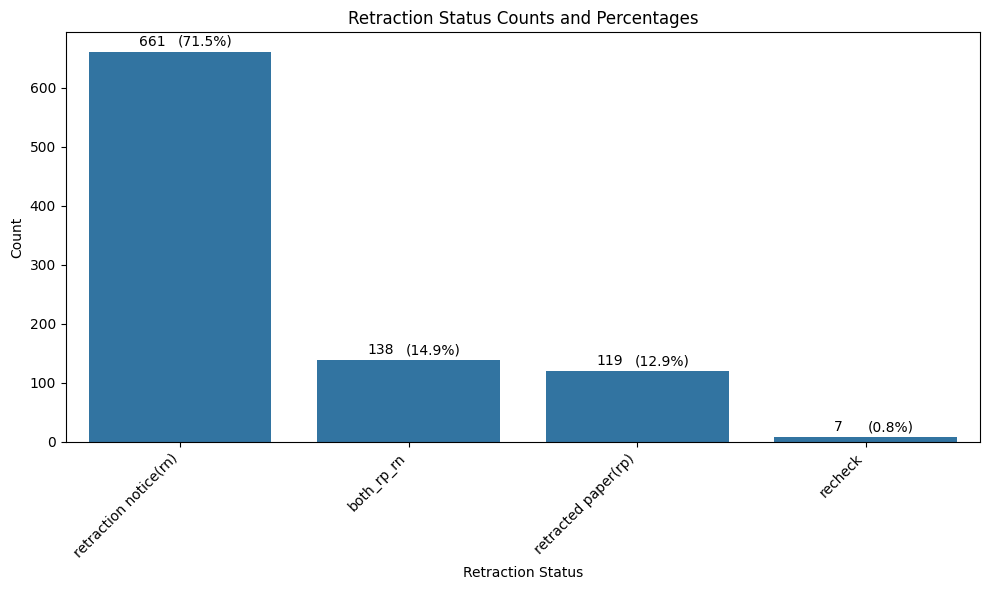

In [432]:

# Bar Chart of Above Data

# A bar chart for the retraction status counts and percentages
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=result.index, y='Count', data=result)

# Add count and percentage labels above each bar
for i, v in enumerate(result['Count']):
    count_label = f"{v}"
    percentage_label = f"({result['Percentage'][i]:.1f}%)"
    ax.text(i-0.12, v + 5, count_label, ha='center', va='bottom', fontsize=10)
    ax.text(i+0.11, v+5, percentage_label, ha='center', va='bottom', fontsize=10)

plt.title('Retraction Status Counts and Percentages')
plt.xlabel('Retraction Status')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [433]:
# Checking breakdown of items that are both retracted & retraction notice
both_df= data_df[data_df['Label']=="both_rp_rn"]


print(f"Total number of items with Retracted Flag: {len(both_df)}")
both_rp_rn_flag_df= both_df['Retraction_Flag'].value_counts().reset_index()

both_rp_rn_flag_df['Percent_count'] = (both_rp_rn_flag_df['count']/len(both_df)*100).round(2)
both_rp_rn_flag_df

Total number of items with Retracted Flag: 138


,Retraction_Flag,count,Percent_count
0,retracted article:,99,71.74
1,retracted:,36,26.09
2,retracted,1,0.72
3,retraction notice,1,0.72
4,statement of retraction,1,0.72


In [434]:
# Overall statistics of the categories in correspondance to likely_retracted and likely_retraction	classes

crosstable_df= pd.crosstab(data_df['Group'],data_df['Label'],) #.reset_index()
crosstable_df

Label,both_rp_rn,recheck,retracted paper(rp),retraction notice(rn)
Group,,,,
likely_retracted,136,0,118,77
likely_retraction,2,7,1,584


In [435]:
crosstable_df2= pd.crosstab(data_df['Group'],data_df['Retraction_Flag_Pos'],) #.reset_index()
crosstable_df2

Retraction_Flag_Pos,begin,end,exact
Group,,,
likely_retracted,327,2,2
likely_retraction,16,44,534


In [436]:
# Calculate the percentage distribution of Retraction_Flag_Pos for each Group
crosstable_percentage_df2 = crosstable_df2.apply(lambda x: x / x.sum(), axis=1) * 100
display(crosstable_percentage_df2.round(2))

Retraction_Flag_Pos,begin,end,exact
Group,,,
likely_retracted,98.79,0.60,0.6
likely_retraction,2.69,7.41,89.9


#### Analysis of Retraction Flags **Before Matching with the Publishers' Retraction Status**

In [437]:
likely_rp_df=data_df[data_df["Group"] == "likely_retracted"]
likely_rn_df=data_df[data_df["Group"] == "likely_retraction"]


print(f"Total number of items with Retracted Flag: {len(likely_rp_df)}")
rp_flag_count_df= likely_rp_df['Retraction_Flag'].value_counts().reset_index()

rp_flag_count_df['Percent_count'] = (rp_flag_count_df['count']/len(likely_rp_df)*100).round(2)
rp_flag_count_df

Total number of items with Retracted Flag: 331


,Retraction_Flag,count,Percent_count
0,retracted article:,163,49.24
1,retracted:,147,44.41
2,retracted chapter:,6,1.81
3,retracted: corrigendum to,5,1.51
4,retracted,4,1.21
5,retracted: retraction notice to,2,0.60
6,retracted: erratum to,1,0.30
7,[retracted],1,0.30
8,<i>retracted:</i>,1,0.30
9,retracted manuscript:,1,0.30


In [438]:
print(f"Total number of items with Retraction Notice Flag: {len(likely_rn_df)}")
rn_flag_count_df= likely_rn_df['Retraction_Flag'].value_counts().reset_index()

rn_flag_count_df['Percent_count'] = (rn_flag_count_df['count']/len(likely_rn_df)*100).round(2)
rn_flag_count_df

Total number of items with Retraction Notice Flag: 594


,Retraction_Flag,count,Percent_count
0,retraction,207,34.85
1,statement of retraction,164,27.61
2,retraction notice,100,16.84
3,statement of removal,32,5.39
4,editorial retraction,16,2.69
5,retraction statement,12,2.02
6,retracted article: statement of retraction,8,1.35
7,notice of retraction,6,1.01
8,retraction note,6,1.01
9,corrigendum,5,0.84


In [439]:
# Analyzing Exact match  - Retracted Flag
likely_rp_df[(likely_rp_df['Retraction_Flag_Pos']== 'exact')]['Retraction_Flag'].value_counts().reset_index()

,Retraction_Flag,count
0,retracted,2


In [440]:
# Analyzing Exact match  - Retraction Notice Flag

print(f"Total number of items Retraction Notice Flag that are in Exact Position (i.e. Flags that appear as Title) : {len(likely_rp_df)}")
rn_exact_count_df= likely_rn_df[(likely_rn_df['Retraction_Flag_Pos']== 'exact')]['Retraction_Flag'].value_counts().reset_index()
rn_exact_count_df['Percent_count'] = (rn_exact_count_df['count']/len(likely_rn_df)*100).round(2)
rn_exact_count_df

Total number of items Retraction Notice Flag that are in Exact Position (i.e. Flags that appear as Title) : 331


,Retraction_Flag,count,Percent_count
0,retraction,166,27.95
1,statement of retraction,164,27.61
2,retraction notice,100,16.84
3,statement of removal,32,5.39
4,editorial retraction,16,2.69
5,retraction statement,11,1.85
6,retracted article: statement of retraction,8,1.35
7,notice of retraction,6,1.01
8,retraction note,4,0.67
9,editorial removal,3,0.51


# **3.General Pattern Retraction Status Analysis and Visualization**


### **Answer To RQ2** - Start

In [441]:
"""
Remove "both_rp_rn", "correction", and "unknown"	from our analysis -> data_df2
"""

data_df2= data_df[(data_df['Label']== 'retracted paper(rp)') | (data_df['Label']== 'retraction notice(rn)')]

data_df2.head()

,Unnamed: 0,DOI,Author,Title,Year,Journal,source,PubMedID,Group,Title_lower,...,Label_ID,Label,Malik_Label_Validation,Jodi_Label_Validation,Remark,Retraction_Phrase,Inference Possibility,Inference Number,Retraction_Flag,Retraction_Flag_Pos
1,75,10.1007/s10586-017-0942-0,"[{'given': 'Chang-Woo', 'family': 'Song', 'seq...",RETRACTED ARTICLE: Development of a medical bi...,2017,Cluster Computing,Crossref,NaN,likely_retracted,retracted article: development of a medical bi...,...,RP52,retracted paper(rp),NaN,NaN,NaN,retracted article,RP52-N,0,retracted article:,begin
2,86,10.1016/j.lfs.2016.05.038,"[{'given': 'Neetu', 'family': 'Kalra', 'sequen...",RETRACTED: Erratum to ‚Äö√Ñ√∫Resveratrol induc...,2016,Life Sciences,Crossref,NaN,likely_retracted,retracted: erratum to ‚Äö√Ñ√∫resveratrol induc...,...,RP179,retraction notice(rn),NaN,NaN,NaN,retracted:,RP179-N,0,retracted: erratum to,begin
3,87,10.1016/j.lfs.2020.117519,Ying Pu;Juan Xiang;Jiani Zhang,RETRACTED: KDM5B-mediated microRNA-448 up-regu...,2020,Life Sciences,PubMed; Crossref,32147429.0,likely_retracted,retracted: kdm5b-mediated microrna-448 up-regu...,...,RP179,retracted paper(rp),NaN,NaN,NaN,retracted:,RP179-N,0,retracted:,begin
4,108,10.1016/j.procs.2017.05.073,"[{'given': 'Nikita', 'family': 'Bukhanov', 'se...",RETRACTED: Clustering of comorbidities based o...,2017,Procedia Computer Science,Crossref,NaN,likely_retracted,retracted: clustering of comorbidities based o...,...,RP228,retraction notice(rn),NaN,NaN,NaN,retracted:,RP228-N,0,retracted:,begin
5,109,10.1016/j.procs.2015.08.298,"[{'given': 'Peter', 'family': 'Luong', 'sequen...",RETRACTED: An adaptive predictor for system pr...,2015,Procedia Computer Science,Crossref,NaN,likely_retracted,retracted: an adaptive predictor for system pr...,...,RP228,retracted paper(rp),NaN,NaN,NaN,retracted:,RP228-N,0,retracted:,begin


In [442]:

# After filtering Other Categories

likely_rp_df2=data_df2[data_df2["Group"] == "likely_retracted"]
likely_rn_df2=data_df2[data_df2["Group"] == "likely_retraction"]

print(f"After Removing Other Labels:")
print(f"Total number of items {len(data_df2)}")
print(f"Total number of items with Retracted Flag: {len(likely_rp_df2)}")
print(f"Total number of items with Retraction Notice Flag: {len(likely_rn_df2)}")

After Removing Other Labels:
Total number of items 780
Total number of items with Retracted Flag: 195
Total number of items with Retraction Notice Flag: 585


In [443]:
# Likely Retracted Before & After filtering Other Categories:
len(likely_rp_df), len(likely_rp_df2)

(331, 195)

In [444]:
# Likely Retraction Notices Before & After filtering Other Categories:
len(likely_rn_df), len(likely_rn_df2)

(594, 585)

In [445]:
# Breakdown of Retracted Flag
retracted_stats_df= likely_rp_df2['Retraction_Flag'].value_counts().reset_index()
retracted_stats_df['count(%)']= (retracted_stats_df['count']/len(likely_rp_df2)) * 100
retracted_stats_df

,Retraction_Flag,count,count(%)
0,retracted:,111,56.923077
1,retracted article:,64,32.820513
2,retracted chapter:,6,3.076923
3,retracted: corrigendum to,5,2.564103
4,retracted,3,1.538462
5,retracted: retraction notice to,2,1.025641
6,retracted: erratum to,1,0.512821
7,[retracted],1,0.512821
8,<i>retracted:</i>,1,0.512821
9,retracted manuscript:,1,0.512821


In [446]:
# Breakdown of Retraction Notice Flag
retraction_stats_df= likely_rn_df2['Retraction_Flag'].value_counts().reset_index()
retraction_stats_df['count(%)']= (retraction_stats_df['count']/len(likely_rn_df2)) * 100
retraction_stats_df

,Retraction_Flag,count,count(%)
0,retraction,206,35.213675
1,statement of retraction,163,27.863248
2,retraction notice,99,16.923077
3,statement of removal,30,5.128205
4,editorial retraction,16,2.735043
5,retraction statement,12,2.051282
6,retracted article: statement of retraction,8,1.367521
7,retraction note,6,1.025641
8,notice of retraction,6,1.025641
9,[retraction],3,0.512821


In [447]:
crosstable_df= pd.crosstab(data_df2['Group'],data_df2['Label'],) #.reset_index()
crosstable_df= crosstable_df.rename(columns={"retracted paper(rp)": "Retracted Paper", "retraction notice(rn)": "Retraction Notice"})
crosstable_df

Label,Retracted Paper,Retraction Notice
Group,,
likely_retracted,118,77
likely_retraction,1,584


In [448]:

crosstable_percent_df = pd.crosstab(data_df2['Group'], data_df2['Label'], normalize='index') * 100
crosstable_percent_df= crosstable_percent_df.rename(columns={"retracted paper(rp)": "Retracted Paper", "retraction notice(rn)": "Retraction Notice"})
crosstable_percent_df.round(2)

Label,Retracted Paper,Retraction Notice
Group,,
likely_retracted,60.51,39.49
likely_retraction,0.17,99.83


In [449]:
(118/195)*100, (77/195)*100, (584/585)*100, (1/585)*100

(60.51282051282051, 39.48717948717949, 99.82905982905983, 0.17094017094017094)

In [450]:
# Filter the DataFrame to include only rows where the original Label is one of the primary types
df=data_df2.copy()

filtered_df_for_user_crosstab = df[df['Label'].isin(['retracted paper(rp)', 'retraction notice(rn)'])].copy()

# Define a new category based on original Group and original Label for the filtered data
def assign_user_category(row):
    # Check for Correct Predictions based on the primary label matching the primary group expectation
    if row['Group'] == 'likely_retracted' and row['Label'] == 'retracted paper(rp)':
        return 'Matched with annotation'
    elif row['Group'] == 'likely_retraction' and row['Label'] == 'retraction notice(rn)':
        return 'Matched with annotation'
    # Check for Incorrect Predictions based on the primary label being the opposite of the primary group expectation
    elif row['Group'] == 'likely_retracted' and row['Label'] == 'retraction notice(rn)':
        return 'Unmatched with annotation'
    elif row['Group'] == 'likely_retraction' and row['Label'] == 'retracted paper(rp)':
        return 'Unmatched with annotation'
    # Rows with other Labels ('both_rp_rn', 'recheck') or other Groups are excluded by the initial filter or will return None
    return None # This case should ideally not be reached with the filter

filtered_df_for_user_crosstab[''] = filtered_df_for_user_crosstab.apply(assign_user_category, axis=1)


# Filter Group to only include the two types of interest
crosstab_user_definition = pd.crosstab(
    filtered_df_for_user_crosstab[filtered_df_for_user_crosstab['Group'].isin(['likely_retracted', 'likely_retraction'])]['Group'],
    filtered_df_for_user_crosstab['']
)

# Ensure column order
if 'Matched with annotation' not in crosstab_user_definition.columns:
     crosstab_user_definition['Matched with annotation'] = 0
if 'Unmatched with annotation' not in crosstab_user_definition.columns:
     crosstab_user_definition['Unmatched with annotation'] = 0
crosstab_user_definition = crosstab_user_definition[['Matched with annotation', 'Unmatched with annotation']]
print(crosstab_user_definition)

                   Matched with annotation  Unmatched with annotation
Group                                                                
likely_retracted                       118                         77
likely_retraction                      584                          1


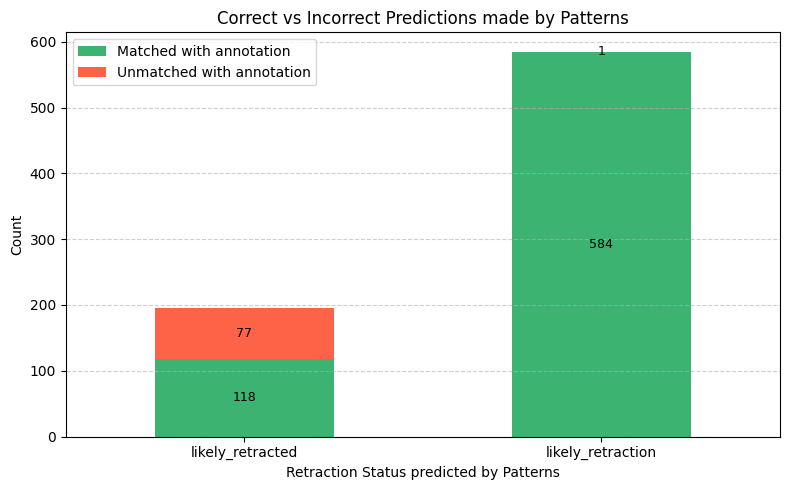

In [451]:
# A stacked bar chart using the crosstab_user_definition DataFrame
ax = crosstab_user_definition.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5),
    color=["mediumseagreen", "tomato"]
)

# Beautify the chart
plt.title("Correct vs Incorrect Predictions made by Patterns")
plt.ylabel("Count")
plt.xlabel("Retraction Status predicted by Patterns")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Add value labels inside the bars
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f'{int(height)}',
                ha='center', va='center',
                fontsize=9, color='black'
            )
# Show the plot
plt.show()

# **4.Analysis for pattern phrases that makes correct and incorrect prediction**


### 4.1 Define necessary retraction phrases set and functions for the follow-up analysis

In [452]:
"""
Annotation & Publisher's are the SAME (Match scenario)
retracted_tp_df - Annotation & Publisher's Status is Retracted (Retracted Flag - the SAME Retracted Status)
retraction_tp_df - Annotation & Publisher's Status is Retraction Notice (Retraction Notice Flag - the SAME Retraction Notice Status)

Annotation & Publisher's are DIFFERENT (Mismatch scenario)
retracted_fp_df - Annotation is Retracted & Publisher's Status is Retraction Notice (Retracted Flag - DIFFERENT Retracted Status)
retraction_fp_df - Annotation  is Retraction Notice  & Publisher's Status is Retracted  (Retraction Notice Flag - DIFFERENT Retraction Notice Status )

"""

retracted_tp_df= data_df2[(data_df2['Group']=='likely_retracted') & \
        (data_df2['Label']=='retracted paper(rp)')]
print(f"# Retracted Flag vs. Publisher's Status - the SAME Retracted Status is {len(retracted_tp_df)}")


retraction_tp_df= data_df2[(data_df2['Group']=='likely_retraction') & \
        (data_df2['Label']=='retraction notice(rn)')]
print(f"# Retraction Notice Flag vs. Publisher's Status  - the SAME Retraction Notice Status is {len(retraction_tp_df)}")


retracted_fp_df= data_df2[(data_df2['Group']=='likely_retracted') & \
        (data_df2['Label']=='retraction notice(rn)')]
print(f"# Retracted Flag vs. Publisher's Status - DIFFERENT Retracted Status is {len(retracted_fp_df)}")



retraction_fp_df= data_df2[(data_df2['Group']=='likely_retraction') & \
        (data_df2['Label']=='retracted paper(rp)')]
print(f"# Retraction Notice Flag vs. Publisher's Status - DIFFERENT Retraction Notice Status is {len(retraction_fp_df)}")


retraction_fp_df

# Retracted Flag vs. Publisher's Status - the SAME Retracted Status is 118
# Retraction Notice Flag vs. Publisher's Status  - the SAME Retraction Notice Status is 584
# Retracted Flag vs. Publisher's Status - DIFFERENT Retracted Status is 77
# Retraction Notice Flag vs. Publisher's Status - DIFFERENT Retraction Notice Status is 1


,Unnamed: 0,DOI,Author,Title,Year,Journal,source,PubMedID,Group,Title_lower,...,Label_ID,Label,Malik_Label_Validation,Jodi_Label_Validation,Remark,Retraction_Phrase,Inference Possibility,Inference Number,Retraction_Flag,Retraction_Flag_Pos
662,814,10.1111/anec.12955,NaN,Retraction,2022,Annals of Noninvasive Electrocardiology,Crossref,NaN,likely_retraction,retraction,...,RN24,retracted paper(rp),NaN,NaN,LY:Title has changed,retraction,RN24-Y,1,retraction,exact


In [453]:
def generate_phrase_wordcloud(df, column, width=800, height=400, bg_color='whitesmoke', cmap='viridis',):  #save_path='wordcloud.png' bg_color='grey' 'whitesmoke'
  """
  It generates a word cloud for a given column in a DataFrame.
  """

  phrases = df[column].dropna().astype(str)
  freq_dict = Counter(phrases)

  wordcloud = WordCloud(width=width, height=height, background_color=bg_color, colormap=cmap).generate_from_frequencies(freq_dict)

  fig = plt.figure(figsize=(width/80, height/80))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud: {column} Phrases', fontsize=20, color='white')
  plt.tight_layout()

  fig = plt.figure(figsize=(10, 5))
  # fig.savefig(save_path, bbox_inches='tight', facecolor='grey')
  plt.close(fig)



In [454]:
def get_stats(df: pd.DataFrame, total_sum: int)-> pd.DataFrame():
  """
  It calculates the frequency & percentage of each column
  """
  stats_df= df['Retraction_Flag'].value_counts().reset_index()
  stats_df['count(%)']= (stats_df['count']/total_sum) * 100

  return stats_df

###4.2 Detail analysis of correct prediction
* DOIs with their **retracted flag** and **retracted status** on publishers' websites are the same.

* DOIs with their **retraction notice flag** and **retraction notice status** on publishers' websites are the same.


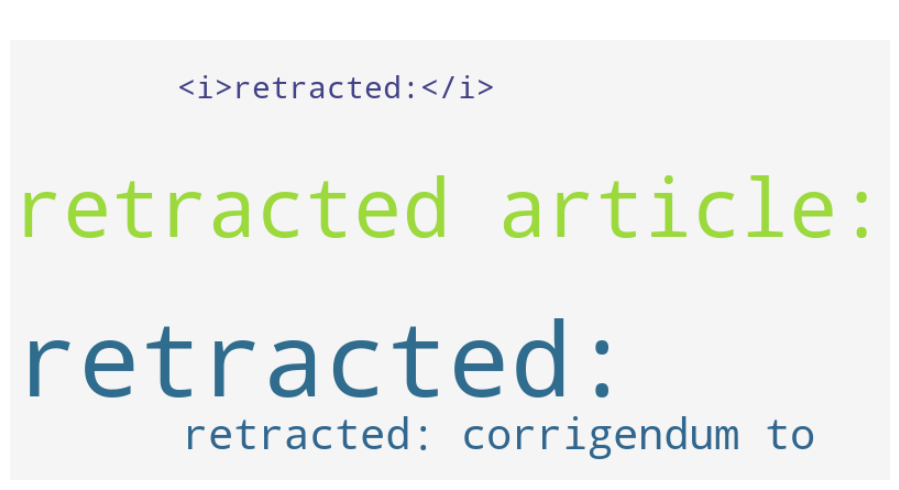

In [455]:

# Generate Wordcloud for Retracted Flag of the SAME Retracted Status
generate_phrase_wordcloud(retracted_tp_df, 'Retraction_Flag',) ## save_path= file_path+"retraction_wordcloud.png"

In [456]:

# Count Retracted Flag that have the SAME Retracted Status
likely_retracted_sum= len(likely_rp_df2)
print(f"Total number of likely_retracted is {likely_retracted_sum}")

# Count SAME Retracted Flag
retracted_tp_stats_df= get_stats(retracted_tp_df, likely_retracted_sum)

save_path_rp_tp= file_path+"retracted_flag_same_status_count.csv"

retracted_tp_stats_df = retracted_tp_stats_df.rename(columns={'count': 'count_tp', 'count(%)': 'count_tp(%)'})

#retracted_tp_stats_df.to_csv(save_path_rp_tp, index=False)

retracted_tp_stats_df

Total number of likely_retracted is 195


,Retraction_Flag,count_tp,count_tp(%)
0,retracted:,71,36.410256
1,retracted article:,44,22.564103
2,retracted: corrigendum to,2,1.025641
3,<i>retracted:</i>,1,0.512821


In [457]:
likely_rp_df2.query(" Retraction_Flag == 'retracted: corrigendum to'")[['DOI', 'Title', 'Label','Retraction_Flag']]

,DOI,Title,Label,Retraction_Flag
6,10.1016/j.matlet.2020.128178,RETRACTED: Corrigendum to ‚Äö√Ñ√∫CH3NH3PbI3 pe...,retraction notice(rn),retracted: corrigendum to
259,10.1016/j.neulet.2019.01.038,RETRACTED: Corrigendum to ‚Äö√Ñ√∫Enriched envi...,retraction notice(rn),retracted: corrigendum to
260,10.1016/j.leaqua.2012.04.001,RETRACTED: Corrigendum to ‚Äö√Ñ√∫Impact of spi...,retracted paper(rp),retracted: corrigendum to
261,10.1016/j.gendis.2021.09.001,RETRACTED: Corrigendum to ‚Äö√Ñ√∫Lipopolysacch...,retracted paper(rp),retracted: corrigendum to
262,10.1016/j.socscimed.2017.11.043,RETRACTED: Corrigendum to ‚Äö√Ñ√∫Structural st...,retraction notice(rn),retracted: corrigendum to


In [458]:
# Recall Retraction Flag Analysis
retracted_stats_df

,Retraction_Flag,count,count(%)
0,retracted:,111,56.923077
1,retracted article:,64,32.820513
2,retracted chapter:,6,3.076923
3,retracted: corrigendum to,5,2.564103
4,retracted,3,1.538462
5,retracted: retraction notice to,2,1.025641
6,retracted: erratum to,1,0.512821
7,[retracted],1,0.512821
8,<i>retracted:</i>,1,0.512821
9,retracted manuscript:,1,0.512821


In [459]:
# retracted: (111) and retracted article:	(64), of which retracted: (71) and retracted article:	(44) are True Positive
print(111+64)
((111+64)/ 195) *100, ((71+44)/195) *100

175


(89.74358974358975, 58.97435897435898)

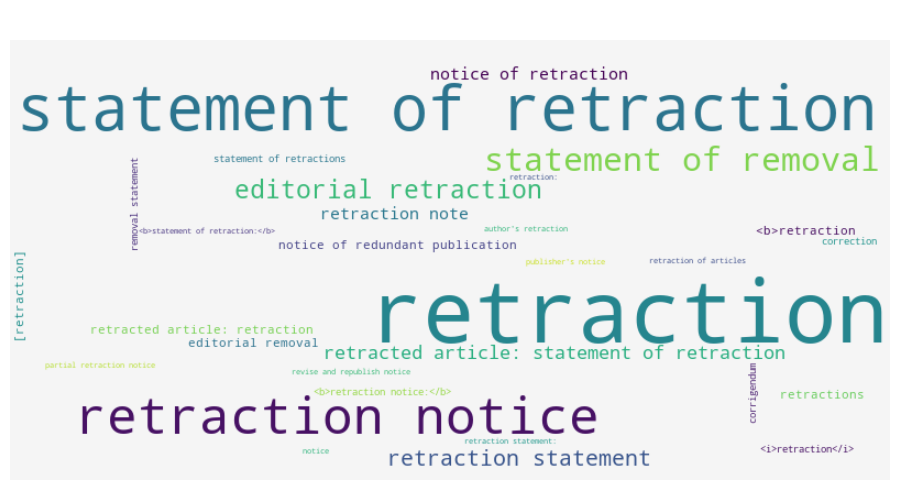

In [460]:
# Generate Wordcloud for Retraction Flag of the SAME Retracted Status
generate_phrase_wordcloud(retraction_tp_df, 'Retraction_Flag',)

In [461]:
len(likely_rn_df2)

585

In [462]:
# Count Retraction Notice Flag that have the SAME Retraction Notice Status
likely_retraction_sum= (data_df2['Group']== 'likely_retraction').sum() #likely_rn_df2

print(f"Total number of likely_retraction is {likely_retraction_sum}")

# get flag counts & percentage
retraction_tp_stats_df= get_stats(retraction_tp_df, likely_retraction_sum)

retraction_tp_stats_df= retraction_tp_stats_df.round(2)
retraction_tp_stats_df = retraction_tp_stats_df.sort_values(by=['count', 'Retraction_Flag',], ascending=False)

save_path_rn_tp= file_path+"retracted_flag_same_status_count.csv"
#retraction_tp_stats_df.to_csv(save_path_rn_tp, index=False)

retraction_tp_stats_df

Total number of likely_retraction is 585


,Retraction_Flag,count,count(%)
0,retraction,205,35.04
1,statement of retraction,163,27.86
2,retraction notice,99,16.92
3,statement of removal,30,5.13
4,editorial retraction,16,2.74
5,retraction statement,12,2.05
6,retracted article: statement of retraction,8,1.37
7,retraction note,6,1.03
8,notice of retraction,6,1.03
14,retractions,3,0.51


In [463]:
print(f"Total Variant Retraction Notice Flag: {retraction_tp_stats_df['Retraction_Flag'].nunique()}")

Total Variant Retraction Notice Flag: 30


In [464]:
# Checking the statistics of the Retraction Notice Flag Positions
# retraction_tp_df['Retraction_Flag_Pos'].value_counts()
likely_rn_df2['Retraction_Flag_Pos'].value_counts()

Retraction_Flag_Pos
exact    529
end       41
begin     15
Name: count, dtype: int64

In [465]:
# Exact
(529/585)*100

90.42735042735043

In [466]:
529+41+15

585

In [467]:
likely_rn_df2['Retraction_Flag'].value_counts()

Retraction_Flag
retraction                                    206
statement of retraction                       163
retraction notice                              99
statement of removal                           30
editorial retraction                           16
retraction statement                           12
retracted article: statement of retraction      8
retraction note                                 6
notice of retraction                            6
[retraction]                                    3
notice of redundant publication                 3
editorial removal                               3
retracted article: retraction                   3
<b>retraction                                   3
retractions                                     3
correction                                      2
statement of retractions                        2
<b>retraction notice:</b>                       2
<i>retraction</i>                               2
removal statement                 

In [468]:
206 + 163+ 99

468

In [469]:
#Correct Retraction notice flag as title
515/len(retraction_tp_df) *100

88.18493150684932

In [470]:
data_df2.query("Retraction_Flag == 'correction' or Retraction_Flag == 'corrigendum'")[['DOI', 'Title']]

,DOI,Title
442,10.3402/gha.v7.24080,Corrigendum
443,10.3402/gha.v7.24079,Corrigendum
611,10.1080/00396338.2020.1833553,Correction
612,10.1080/13636820.2020.1870837,Correction


###4.3 Detailed Analysis of Incorrect prediction
In this section,we breaked the case of incorrect retraction flag down into 2 specific cases:


*   DOIs that **retracted flag** but have **retraction notices status** on Publishers' websites
*   DOIs that **retraction notice flag** but have **retracted status** on Publishers' websites

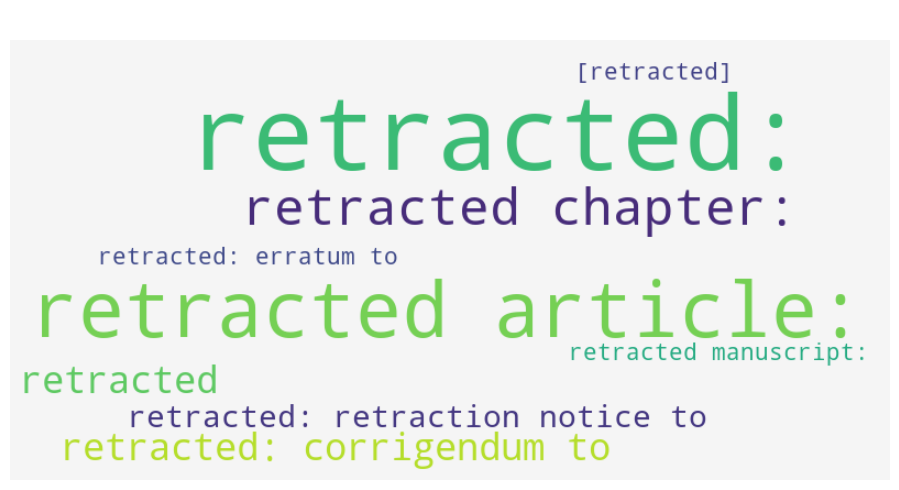

In [471]:
# Generate Wordcloud for Retracted Flag that has Flag that have Retraction Notice Status(DIFFERENT)
generate_phrase_wordcloud(retracted_fp_df, 'Retraction_Flag',)

In [472]:
# Count Retracted Flag that have DIFFERENT Retraction Notice Status (Unmatch)

likely_retracted_sum= (data_df2['Group']== 'likely_retracted').sum()
print(f"Total number of likely_retracted is {likely_retracted_sum}")

retracted_fp_stats_df= get_stats(retracted_fp_df, likely_retracted_sum)

retracted_fp_stats_df= retracted_fp_stats_df.round(2)
retracted_fp_stats_df = retracted_fp_stats_df.rename(columns={'count': 'count_fp', 'count(%)': 'count_fp(%)'})
save_path_rp_fp= file_path+"retracted_flag_different_status_count.csv"
#retracted_fp_stats_df.to_csv(save_path_rp_fp, index=False)

retracted_fp_stats_df

Total number of likely_retracted is 195


,Retraction_Flag,count_fp,count_fp(%)
0,retracted:,40,20.51
1,retracted article:,20,10.26
2,retracted chapter:,6,3.08
3,retracted: corrigendum to,3,1.54
4,retracted,3,1.54
5,retracted: retraction notice to,2,1.03
6,retracted: erratum to,1,0.51
7,[retracted],1,0.51
8,retracted manuscript:,1,0.51


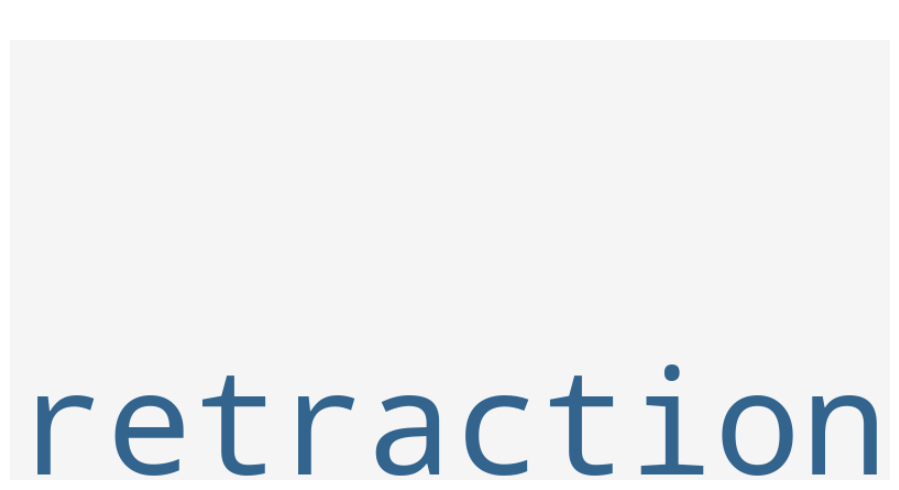

In [473]:
# Generate Wordcloud for Retraction Notice Flag that has Retracted Status(DIFFERENT)
generate_phrase_wordcloud(retraction_fp_df, 'Retraction_Flag',)

In [474]:
likely_retraction_sum= (data_df2['Group']== 'likely_retracted').sum()
print(f"Total number of likely_retracted is {likely_retraction_sum}")

retraction_fp_stats_df= get_stats(retraction_fp_df, likely_retraction_sum)


save_path_rn_fp= file_path+"retraction_flag_different_status_count.csv"
#retraction_fp_stats_df.to_csv(save_path_rn_fp, index=False)

retraction_fp_stats_df

Total number of likely_retracted is 195


,Retraction_Flag,count,count(%)
0,retraction,1,0.512821
